# MNIST (TensorFlow)

[![Open in Colab](https://lab.aef.me/files/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/lab/blob/main/files/tf/mnist.ipynb)
[![Open in Kaggle](https://lab.aef.me/files/assets/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/adamelliotfields/lab/blob/main/files/tf/mnist.ipynb)
[![Render nbviewer](https://lab.aef.me/files/assets/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/lab/blob/main/files/tf/mnist.ipynb)

[MNIST](https://keras.io/api/datasets/mnist/) classifier using the [LeNet-5](http://yann.lecun.com/exdb/lenet/) architecture. Explore the dataset on [Know Your Data](https://knowyourdata-tfds.withgoogle.com/#dataset=mnist).

> NB: Training is 10x faster on GPU.

In [1]:
%matplotlib inline

import io
import os
import pickle

import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import tensorflow as tf

from IPython.display import display, HTML
from PIL import Image
from keras import Input, Sequential, datasets, layers, models

In [2]:
# @title Functions
EPOCHS = 10
VAL_SIZE = 3000
TRAIN_SIZE = 57000
BATCH_SIZE = 200
MODEL_PATH = "mnist.keras"
HISTORY_PATH = "mnist-history.pkl"
AUTOTUNE = tf.data.AUTOTUNE


def prepare_image(image):
    image = tf.expand_dims(image, -1)
    return tf.image.convert_image_dtype(image, tf.float32)


def prepare_data(X, y):
    image = prepare_image(X)
    label = tf.one_hot(y, 10)
    return image, label


def get_dataset():
    (X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

    mnist_train = (
        tf.data.Dataset.from_tensor_slices((X_train, y_train))
        .map(prepare_data, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )
    mnist_test = (
        tf.data.Dataset.from_tensor_slices((X_test, y_test))
        .map(prepare_data, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )
    return mnist_train, mnist_test


def get_model(cache=True, with_history=False, verbose=0):
    if cache and os.path.exists(MODEL_PATH) and os.path.exists(HISTORY_PATH):
        model = models.load_model(MODEL_PATH)
        with open(HISTORY_PATH, "rb") as f:
            history = pickle.load(f)
    else:
        ds_train, _ = get_dataset()

        model = Sequential(
            [
                Input(shape=(28, 28, 1)),
                layers.Conv2D(6, (5, 5), padding="same", strides=1, activation="tanh"),
                layers.MaxPooling2D((2, 2), strides=2),
                layers.Conv2D(16, (5, 5), strides=1, activation="tanh"),
                layers.MaxPooling2D((2, 2), strides=2),
                layers.Conv2D(120, (5, 5), strides=1, activation="tanh"),
                layers.Flatten(),
                layers.Dense(84, activation="tanh"),
                layers.Dense(10, activation="softmax"),
            ]
        )
        model.compile(
            optimizer="sgd",
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

        history = model.fit(
            ds_train.take(TRAIN_SIZE // BATCH_SIZE),
            epochs=EPOCHS,
            verbose=verbose,
            validation_data=ds_train.skip(TRAIN_SIZE // BATCH_SIZE).take(VAL_SIZE // BATCH_SIZE),
        )

        model.save(MODEL_PATH)
        with open(HISTORY_PATH, "wb") as f:
            pickle.dump(history, f)

    if with_history:
        return model, history

    return model


def show_dataset(ds):
    plt.figure(figsize=(8, 4))
    for i, (image, label) in enumerate(ds.unbatch().take(10)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(tf.squeeze(image), cmap="gray")
        plt.title(tf.argmax(label).numpy())
        plt.axis("off")
    plt.show()


def plot_history(history, metrics, epochs):
    _, ax1 = plt.subplots()
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_xticks(range(epochs))

    # TODO: loop
    sns.lineplot(
        history.history["loss"],
        ax=ax1,
        label="Train Loss",
        marker="o",
        color="blue",
        dashes=False,
        legend=False,
    )
    sns.lineplot(
        history.history["val_loss"],
        ax=ax1,
        label="Val Loss",
        marker="s",
        color="red",
        dashes=False,
        legend=False,
    )

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")

    sns.lineplot(
        history.history["accuracy"],
        ax=ax2,
        label="Train Accuracy",
        marker="D",
        color="orange",
        dashes=False,
        legend=False,
    )
    sns.lineplot(
        history.history["val_accuracy"],
        ax=ax2,
        label="Val Accuracy",
        marker="^",
        color="green",
        dashes=False,
        legend=False,
    )

    # combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="center right")

    # add text below legend
    plt.gcf().text(
        0.8875,
        0.625,
        f"Test Loss: {metrics[0]:.2}\nTest Accuracy: {metrics[1]:.2}",
        horizontalalignment="right",
        verticalalignment="center",
    )
    plt.title("LeNet-5 MNIST Training")
    plt.show()

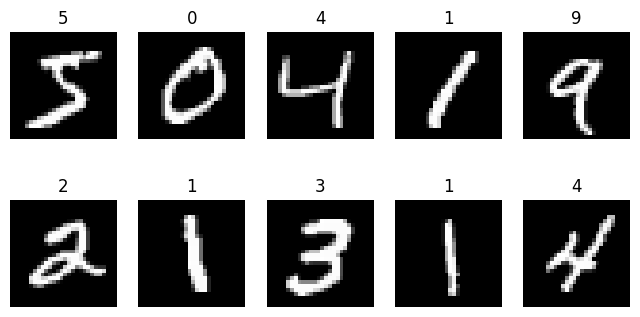

In [3]:
mnist_train, mnist_test = get_dataset()
show_dataset(mnist_train)

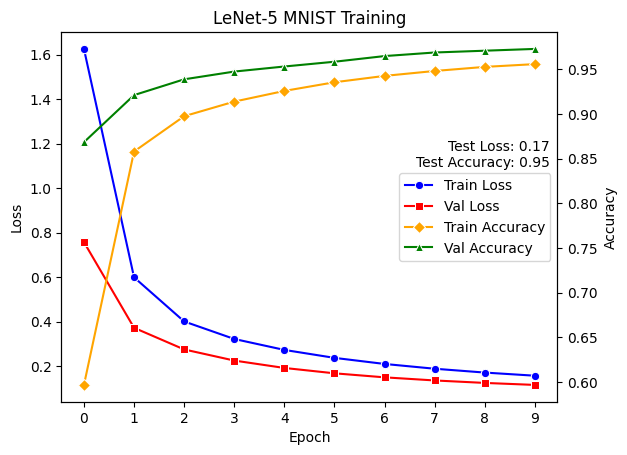

In [4]:
model, history = get_model(with_history=True, verbose=0)
metrics = model.evaluate(mnist_test.take(2000 // BATCH_SIZE), verbose=0)
plot_history(history, metrics, EPOCHS)

## Demo

Select a class from 0-9 using the combobox and then select an image from the list to preview it. Press the "Predict" button to see the model's classification. These are samples **not** seen during training.

In [ ]:
# @title App with ipywidgets
X_test_slice, y_test_slice = [], []
for image, label in mnist_test.unbatch().take(100):
    X_test_slice.append(tf.squeeze(image).numpy())
    y_test_slice.append(tf.argmax(label).numpy())

# styling is a little off in colab
class_combobox = widgets.Combobox(
    options=[str(i) for i in range(10)],
    description="Class:",
    ensure_option=False,
    value="",
)

index_select = widgets.Select(
    layout={"height": "107px"},
    options=[],
    description="Index:",
    disabled=True,
    value=None,
)

image_widget = widgets.Image(
    layout={"height": "140px", "width": "140px", "border": "1px solid lightgray"},
    format="png",
)

predict_button = widgets.Button(
    layout={"margin": "0 0 0 2px", "width": "110px"},
    description="Predict",
    button_style="success",
)

output_widget = widgets.Output(
    layout={"height": "110px", "width": "110px", "border": "1px solid lightgray"}
)


def update_class(change):
    selected_class = change["new"]

    if selected_class != "":
        selected_class = int(selected_class)
        indices = [i for i, label in enumerate(y_test_slice) if label == selected_class]
        index_select.options = indices
        index_select.value = indices[0]
        index_select.disabled = False
    else:
        indices = []
        index_select.value = None
        index_select.options = []
        index_select.disabled = True

    output_widget.clear_output()


def get_image(index):
    if index is None:
        # 1x1 transparent png
        img = Image.new("RGBA", (1, 1), (0, 0, 0, 0))
    else:
        img = Image.fromarray(X_test_slice[index] * 255)
        if img.mode == "F":
            img = img.convert("L")  # convert to grayscale

    buf = io.BytesIO()
    img.save(buf, format="PNG")

    return buf.getvalue()


def update_image(change):
    selected_index = change["new"]

    if index_select.value is not None and selected_index != "":
        selected_index = int(selected_index)
        image_widget.value = get_image(selected_index)
    else:
        image_widget.value = get_image(None)

    output_widget.clear_output()


def predict(_):
    global model
    selected_index = index_select.value

    if selected_index is not None:
        x = X_test_slice[index_select.value]
        x = prepare_image(x)[tf.newaxis, ...]
        y_preds = model.predict(x, verbose=0)
        y_preds = tf.argmax(y_preds, axis=-1).numpy()
        with output_widget:
            output_widget.clear_output()
            display(
                HTML(
                    f'<h1 style="font-family: monospace; font-size: 48px; text-align: center;">{y_preds[0]}</h1>'
                )
            )


image_widget.value = get_image(None)

class_combobox.observe(update_class, names="value")
index_select.observe(update_image, names="value")
predict_button.on_click(predict)

vbox1 = widgets.VBox([class_combobox, index_select])
vbox2 = widgets.VBox([image_widget], layout={"overflow": "hidden"})
vbox3 = widgets.VBox([output_widget, predict_button])

widgets.HBox([vbox1, vbox2, vbox3])